## 1. Gather Data

In [188]:
# first do all the necessary imports here

import numpy as np
import pandas as pd
import seaborn as sns
import tweepy
import json
import time
import re
import requests
import matplotlib.pyplot as plt
import matplotlib.axes._axes as axes
sns.set()

We already have the `twitter_archive_enhanced.csv` in hand. So the 
remaining 2 data that we need to gather programmatically are the 
`image_predictions.tsv` file from the Udacity server and the tweet 
jsdon metdata from the Twitter API.

In [189]:
# first get the image_predictions.tsv file and write the contents 
# to a local file

udacity_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
res = requests.get(udacity_url)
res

<Response [200]>

Since we have a 200 http response from the server, we know that we 
have a valid reply, so in the next step we proceed to write the 
response contents into a local file.

In [190]:
with open('image_predictions.tsv', mode='wb') as file:
    file.write(res.content)

Next, we will use the Twitter API to get the relevant JSON metadata
 against each tweet id present in the archived dataset.

In [191]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, 
                 wait_on_rate_limit_notify=True)

In [ ]:
archived_df = pd.read_csv('twitter-archive-enhanced.csv')
start = time.time()
json_status_list = []
error_list = []
for tweetId in archived_df.tweet_id.values:
    try:
        tweet = api.get_status(tweetId)
        json_status_list.append(tweet._json)
    except Exception as msg:
        error_list.append(str(tweetId) + ': ' + str(msg) + '\n\r')    
end = time.time()
elapsed = end - start
print(f"The process took {elapsed//60} min and {elapsed%60:0.2f} sec")

We will be saving all the valid json responses from the 
Twitter API into a file called `tweet-json-me.txt`.

In [ ]:
with open('tweet-json-me.txt', mode='a') as f1:
    for tweet_dict in json_status_list:
        json_string = json.dumps(tweet_dict)
        f1.write(json_string)
        f1.write('\n')

In [ ]:
with open('tweet-json-me.txt', mode='r') as f2:
    all_lines = f2.readlines()

Finally we will be converting all the twitter API responses into a 
pandas dataframe with `retweet count`, `favorite count` and `tweet 
count` as columns. 

In [ ]:
tweet_api_df_list = []
for line in all_lines:
    if line != '\n':
        json_tweet = json.loads(line)
        tweet_api_df_list.append({
            'tweet_id': json_tweet['id'],
            'favorite_count': json_tweet['favorite_count'],
            'retweet_count': json_tweet['retweet_count']
        })

In [ ]:
tweet_api_df = pd.DataFrame(tweet_api_df_list)
tweet_api_df.head()

Let us convert the dataframe into a csv file so that we can use it 
later.

In [ ]:
tweet_api_df.to_csv('twitter_api_df.csv', index=False)

At this point, all the 3 sources of data have been explored and the
data has been collected. The next stage is that of data assessment.
 
## 2.(a) Assess and Clean - `twitter-archive-enhanced.csv`
I. We will first look at the `twitter-archive-enhanced.csv` dataset
Below we will concurrently do some programmatic and visual 
assessment to identify issues with the dataset.

In [192]:
# lets look at the info of the dataset
twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [193]:
twitter_archive_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


Issues found in the dataset are as follows:

(i) Data Quality
1. the `source` column contains device source information of the
tweet. It will have to be standardised and simplified so that it only
reflects the device platform name and redundant url information are 
removed.
2.  the `in_reply_to_status_id`, `in_reply_to_user_id` columns 
correspond to reply tweets with 
no image urls. These records will have to be dropped as they do not
 represent original tweets.
3. some dog names are 'a' or 'an' while many other rows show dog 
names with 'None'. These rows will have to be checked to see if the 
dog names can be extracted or not.
4. some of the `expanded_urls` data cells show repeatation of the 
same url. those repeatations will have to be programmatically removed.
5. the `retweeted_status_id`, `retweeted_status_user_id` and 
`retweeted_status_timestamp` columns correspond to retweets and 
hence those tweet records will have to be removed since we are only
 concentrating on original tweets.
6. consequently, not only the rows but the columns mentioned in 
points (2) and (5) will have to be programmatically removed since 
they will no longer have relevance as the final dataset will not 
have retweets or reply tweets. 
7. The datatype of the timestamp column is object and it has to be 
converted into a datetime object.
8. Null or NaN values are represented as "None" in the dataset, 
giving an illusion that these are valid data. The "None" cells in 
the datset will have to be replaced with NaN.

(ii) Tidyness
1. It is redundant to have 4 separate columns for the stage of a 
dog. A single column is sufficient with the 3 possible states of 
`doggo`, `floofer`, `pupper` and `puppo`. 

II. Below, we will proceed with the cleaning of the dataset.

In [194]:
# first address quality issue 1.

# define a function that will apply on the source column and simplify the url
# string into a simplified platform name
sources = ['iphone', 'Web Client', 'Vine', 'TweetDeck']
def simplify_source(cell):
    for source in sources:
        if source in cell:
            return source.lower()

# apply the function to the source column of the dataframe
twitter_archive_df_clean = twitter_archive_df.copy() # type: pd.DataFrame
twitter_archive_df_clean['source'] = twitter_archive_df_clean['source'].apply(simplify_source)

# TEST - check if the source column has been simplified
twitter_archive_df_clean.source.value_counts()

iphone        2221
vine            91
web client      33
tweetdeck       11
Name: source, dtype: int64

In [195]:
# remove rows mentioned in quality issue 2.

rows_to_be_dropped = \
    twitter_archive_df_clean[~twitter_archive_df_clean
    ['in_reply_to_status_id'].isna()].index
twitter_archive_df_clean.drop(labels=rows_to_be_dropped, axis=0,inplace=True) 

In [196]:
# Test -  shape should be zero                             
twitter_archive_df_clean[~twitter_archive_df_clean
['in_reply_to_status_id'].isna()].shape[0]

0

In [197]:
# remove rows mentioned in quality issue 5.

rows_to_be_dropped = \
    twitter_archive_df_clean[~twitter_archive_df_clean
    ['retweeted_status_id'].isna()].index
twitter_archive_df_clean.drop(labels=rows_to_be_dropped, axis=0, 
                              inplace=True)
# Test - shape should be zero
twitter_archive_df_clean[~twitter_archive_df_clean
    ['retweeted_status_id'].isna()].shape[0]

0

In [198]:
# remove columns mentioned in quality issue 6
cols_to_remove = ['in_reply_to_status_id', 
                  'in_reply_to_user_id', 
                  'retweeted_status_id', 
                  'retweeted_status_user_id', 
                  'retweeted_status_timestamp']
twitter_archive_df_clean.drop(labels=cols_to_remove, axis=1, 
                              inplace=True)

In [199]:
# convert datatype of timestamp to datetime object for issue 7
twitter_archive_df_clean['timestamp'] = \
    pd.to_datetime(twitter_archive_df_clean['timestamp'])

# Test - check dtype of tiemstamp
twitter_archive_df_clean['timestamp'].dtype

datetime64[ns, UTC]

In [200]:
#  solve quality issue 8 and tidyness issue 1.

# replace Nones in dog stages with empty strings
dog_stages = ['doggo', 'floofer', 'pupper', 'puppo']
for stage in dog_stages:
    twitter_archive_df_clean[stage].replace('None', "", inplace=True)
    
dog_stage_list = []
for _, series in twitter_archive_df_clean.iterrows():
    dog_stage_list.append( series['doggo'] or series['floofer'] or series['pupper'] or series['puppo'])
twitter_archive_df_clean['dog_stage'] = pd.Series(dog_stage_list, index=twitter_archive_df_clean.index)

# finally drop the redundant columns
twitter_archive_df_clean.drop(labels=dog_stages, inplace=True, axis=1)

# finally replace the " is dog_stage with NaN"
twitter_archive_df_clean.dog_stage.replace("", np.nan, inplace=True)

In [201]:
# solving data quality issue 4

# first get a list of all possible urls
url_list_of_lists = twitter_archive_df_clean.expanded_urls.str.split(',')

# from repeat urls, remove repeats or urls that are not from twitter
final_url_list = []
for url_list in url_list_of_lists:
    if isinstance(url_list, list) and len(url_list) > 1:
        for url in url_list:
            m =re.search('twitter', url)
            if m:
                final_url_list.append(m.string)
                break
    elif isinstance(url_list, list) and len(url_list) == 1:
        final_url_list.append(url_list[0])
    else:
        final_url_list.append("NaN")


In [202]:
# finally add the new urls as the expanded urls column
twitter_archive_df_clean.expanded_urls = pd.Series(final_url_list, index=twitter_archive_df_clean.index)

In [203]:
# lets look at all possible values of the dog names
twitter_archive_df_clean.name.value_counts()

None         603
a             55
Charlie       11
Lucy          11
Oliver        10
Cooper        10
Tucker         9
Penny          9
the            8
Winston        8
Sadie          8
Lola           8
Daisy          7
Toby           7
Stanley        6
Bailey         6
Bella          6
an             6
Jax            6
Koda           6
Oscar          6
Bo             6
Scout          5
Leo            5
Chester        5
Bentley        5
Rusty          5
Milo           5
Dave           5
Louis          5
            ... 
Monkey         1
Hazel          1
Pilot          1
Petrick        1
Jebberson      1
Jessifer       1
Samsom         1
Baron          1
Zara           1
Lizzie         1
Shikha         1
Bode           1
Scruffers      1
Dutch          1
Chubbs         1
River          1
Emma           1
Alfy           1
Mona           1
Mutt           1
Tonks          1
Godi           1
Kevon          1
life           1
Kollin         1
Clarkus        1
Tess           1
Sailor        

In [204]:
# name column shows invalid names like 'a', 'an','the', 'such', 'my', 'None' => remove these names with NaN

names_to_replace = ['a', 'an','the', 'such', 'my', 'None']
twitter_archive_df_clean['name'].replace(to_replace=names_to_replace, value=np.nan, inplace=True)

In [205]:
#Test - an empty dataframe should return
twitter_archive_df_clean.query('name == "a" | name == "an" | name == "the" |name =="such" |name == "my"')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage


## 2.(b) Assess and Clean - `twitter-api-df.csv`

I. We will first look at the `twitter-api-df.csv` dataset
Below we will concurrently do some programmatic and visual 
assessment to identify issues with the dataset.

In [206]:
# lets look at the first few lines of the API dataset

twitter_api_df = pd.read_csv("twitter_api_df.csv")
twitter_api_df.head()

,favorite_count,retweet_count,tweet_id
0,37220,7975,892420643555336193
1,32014,5920,892177421306343426
2,24101,3911,891815181378084864
3,40542,8122,891689557279858688
4,38766,8807,891327558926688256


In [207]:
twitter_api_df_clean = twitter_api_df.copy()
twitter_api_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332 entries, 0 to 2331
Data columns (total 3 columns):
favorite_count    2332 non-null int64
retweet_count     2332 non-null int64
tweet_id          2332 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


Since the data comes from an API, both from visual and programmatic means, there was no major discrepency found in the API dataset. However, the following tidyness issue is to be solved:

(i) Tidyness:

1. this dataset refers to respective favorite count and retweet counts of tweets and hence cannot remain as a separate dataset file as it violates the law of data tidyness. We have to merge this with the tweeter archive dataset that we previously worked on to have a master tweeter dataset.

In [208]:
# below, we will do an inner merge of the 2 datasets on the tweet_id as the key 
twitter_master_df = pd.merge(twitter_archive_df_clean.copy(), twitter_api_df_clean, on='tweet_id')

# finally save this master dataframe as twitter_master_df.csv
twitter_master_df.to_csv('twitter_master_df.csv', index=False)

## 2.(c) Assess and Clean - `image_predictions.tsv`


I. We will first look at the `image_predictions.tsv` dataset.
Below we will concurrently do some programmatic and visual 
assessment to identify issues with the dataset.

In [209]:
image_predictions_df = pd.read_csv('image_predictions.tsv', sep='\t')
image_predictions_df.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
76,667435689202614272,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,1,Rottweiler,0.999091,True,miniature_pinscher,0.000450,True,black-and-tan_coonhound,0.000157,True
1007,709198395643068416,https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg,1,borzoi,0.490783,True,wire-haired_fox_terrier,0.083513,True,English_setter,0.083184,True
2057,888804989199671297,https://pbs.twimg.com/media/DFWra-3VYAA2piG.jpg,1,golden_retriever,0.469760,True,Labrador_retriever,0.184172,True,English_setter,0.073482,True
781,689999384604450816,https://pbs.twimg.com/media/CZNexghWAAAYnT-.jpg,1,standard_poodle,0.444499,True,English_springer,0.129830,True,pug,0.073806,True
173,669006782128353280,https://pbs.twimg.com/media/CUjKHs0WIAECWP3.jpg,1,Chihuahua,0.127178,True,Italian_greyhound,0.054215,True,pillow,0.048592,False
612,680130881361686529,https://pbs.twimg.com/media/CXBPbVtWAAA2Vus.jpg,1,Maltese_dog,0.199121,True,West_Highland_white_terrier,0.197897,True,Shih-Tzu,0.157130,True
1509,785927819176054784,https://pbs.twimg.com/media/CugtKeXWEAAamDZ.jpg,1,teddy,0.972070,False,toy_poodle,0.008493,True,chow,0.002883,True
1149,731285275100512256,https://pbs.twimg.com/media/CiYME3tVAAENz99.jpg,1,Pembroke,0.967103,True,Cardigan,0.021126,True,Chihuahua,0.002231,True
989,707969809498152960,https://pbs.twimg.com/media/CdM2xRpXEAUsR4k.jpg,1,toy_poodle,0.908491,True,miniature_poodle,0.082652,True,teddy,0.005786,False
501,675853064436391936,https://pbs.twimg.com/media/CWEcxqWVEAAHyGH.jpg,1,Labrador_retriever,0.868367,True,golden_retriever,0.043305,True,vizsla,0.028207,True


In [210]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [211]:
image_predictions_df.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
Chesapeake_Bay_retriever      23
miniature_pinscher            23
seat_belt                     22
Staffordshire_bullterrier     20
German_shepherd               20
Siberian_husky                20
Cardigan                      19
web_site                      19
Eskimo_dog                    18
Maltese_dog                   18
teddy                         18
Shetland_sheepdog             18
beagle                        18
Shih-Tzu                      17
Rottweiler                    17
Lakeland_terrier              17
Italian_greyhound             16
kuvasz                        16
          

From the programmatic and visual assessments we only find 2 issues with this dataset. They are as follows:

(i) Data Quality:

1. the p1, p2 and p3 columns contain non standardised dog breed names with a mix of upper case and lower case names. these will have to be standardised and everything will be converted to lower case.

(ii) Tidyness:

1. The information in the `image_predictions.tsv` file are only relevant to the output of image classification algorithm on the tweet images. Therefore, following the principle of data tidyness, this dataset will not be merged with the `tweet_master_df` dataframe. 

In [212]:
image_predictions_df.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [213]:
# convert and standardise the prediction names to lower case

for i in range(1, 4):
    image_predictions_df['p'+ str(i)]= image_predictions_df['p'+str(i)].str.lower()
    
# check the head of the dataframe to see if the names are now in lower case or not
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


## 3.Storing Data and Further Analysis

At this point, we have 2 separate dataframes in hand, namely the `twitter_master_df` dataframe which we have already stored as a csv file and the `image_predictions_df` dataframe which we will store as a csv file below.

In [214]:
image_predictions_df.to_csv('image_predictions_df.csv', index=False)

Now that both the dataframes are saved, we will perform some statistical analysis on both the dataframes to get some useful insights.

In [215]:
# Lets take a look at our twitter dataframe again
twitter_master_df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56+00:00,iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,37220,7975
1,892177421306343426,2017-08-01 00:17:27+00:00,iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,32014,5920
2,891815181378084864,2017-07-31 00:18:03+00:00,iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,24101,3911
3,891689557279858688,2017-07-30 15:58:51+00:00,iphone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,40542,8122
4,891327558926688256,2017-07-29 16:00:24+00:00,iphone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,38766,8807


In [216]:
# do some necessary import for image processing

from PIL import Image
from io import BytesIO

Tweet id with highest favorite count: 744234799360020481
Tweet text with highest favorite count:
 Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4
Tweet source with highest favorite count:
 iphone
Tweet retweet count with highest favorite count:
 80500
Dog Rating with highest favorite count:
 13/10
Dog stage with highest favorite count:
 doggo
Predicted dog breed:
 labrador_retriever


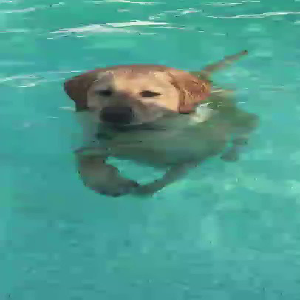

In [217]:
# Insight 1 - the tweet and dog picture with the highest number of favorite counts

# first sort the dataframe according to favorite count
sorted_twitter_df_by_favorite = twitter_master_df.sort_values(by='favorite_count', ascending=False)

# get the tweet with the highest favorite count
tweet_with_highest_fav = sorted_twitter_df_by_favorite.iloc[0]

# get the tweet_id with highest favorite count
tweet_id_with_highest_fav = tweet_with_highest_fav['tweet_id']

# get the algorithm prediction on the dog with the highest confidence
predicted_breed = image_predictions_df[image_predictions_df.tweet_id == tweet_id_with_highest_fav]["p1"].values[0]

# show output
print(f"Tweet id with highest favorite count: {tweet_id_with_highest_fav}")
print(f"Tweet text with highest favorite count:\n {tweet_with_highest_fav['text']}")
print(f"Tweet source with highest favorite count:\n {tweet_with_highest_fav['source']}")
print(f"Tweet retweet count with highest favorite count:\n {tweet_with_highest_fav['retweet_count']}")
print(f"Dog Rating with highest favorite count:\n {tweet_with_highest_fav['rating_numerator']}/{tweet_with_highest_fav['rating_denominator']}")
#print(f"Dog name highest favorite count: {tweet_with_highest_fav['name']}") 
print(f"Dog stage with highest favorite count:\n {tweet_with_highest_fav['dog_stage']}")
print(f"Predicted dog breed:\n {predicted_breed}")     
      
# below we show the image of the tweet - this is where we will use the image dataset
image_url = image_predictions_df[image_predictions_df.tweet_id == tweet_id_with_highest_fav]['jpg_url'].values[0]
if image_url:
      image_res = requests.get(image_url)
i = Image.open(BytesIO(image_res.content)).resize((300,300))
i     

Tweet id with highest retweet count: 744234799360020481
Tweet text with highest retweet count:
 Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4
Tweet source with highest retweet count:
 iphone
Tweet retweet count with highest retweet count:
 80500
Dog Rating with highest retweet count:
 13/10
Dog stage with highest retweet count:
 doggo
Predicted dog breed:
 labrador_retriever


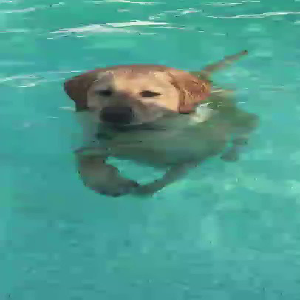

In [218]:
# Insight 2 - the tweet and dog picture with the highest number of retweet counts

# first sort the dataframe according to retweet count
sorted_twitter_df_by_retweet = twitter_master_df.sort_values(by='retweet_count', ascending=False)

# get the tweet with the highest retweet count
tweet_with_highest_retweet = sorted_twitter_df_by_retweet.iloc[0]

# get the tweet_id with highest retweet count
tweet_id_with_highest_retweet = tweet_with_highest_retweet['tweet_id']

# get the algorithm prediction on the dog with the highest confidence
predicted_breed = image_predictions_df[image_predictions_df.tweet_id == tweet_id_with_highest_retweet]["p1"].values[0]

# show output
print(f"Tweet id with highest retweet count: {tweet_id_with_highest_retweet}")
print(f"Tweet text with highest retweet count:\n {tweet_with_highest_retweet['text']}")
print(f"Tweet source with highest retweet count:\n {tweet_with_highest_retweet['source']}")
print(f"Tweet retweet count with highest retweet count:\n {tweet_with_highest_retweet['retweet_count']}")
print(f"Dog Rating with highest retweet count:\n {tweet_with_highest_retweet['rating_numerator']}/{tweet_with_highest_retweet['rating_denominator']}")
#print(f"Dog name highest favorite count: {tweet_with_highest_fav['name']}") 
print(f"Dog stage with highest retweet count:\n {tweet_with_highest_retweet['dog_stage']}")
print(f"Predicted dog breed:\n {predicted_breed}")      
      
# below we show the image of the tweet - this is where we will use the image dataset
image_url = image_predictions_df[image_predictions_df.tweet_id == tweet_id_with_highest_fav]['jpg_url'].values[0]
if image_url:
      image_res = requests.get(image_url)
i = Image.open(BytesIO(image_res.content)).resize((300,300))
i   

From insights 1 and 2 it is clear that the most favorite tweet is also the most retweeted tweet

Text(0, 0.5, 'Source Platform %')

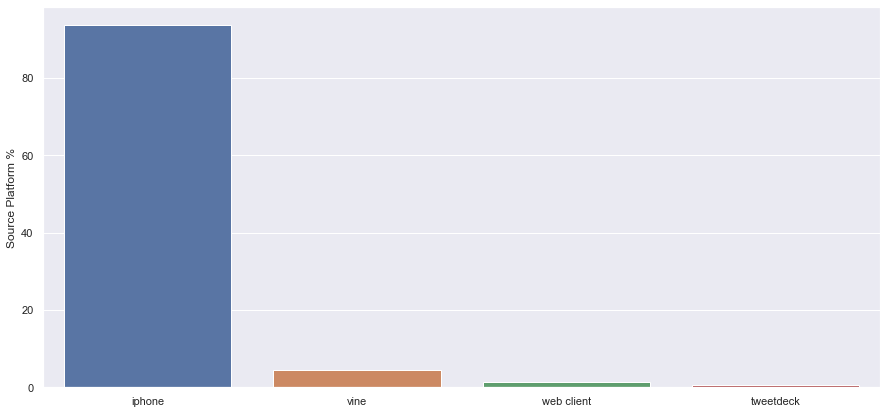

In [219]:
# Insight 3 - finding the % contribution of tweet platform sources via barchart

total = sum(twitter_master_df.source.value_counts())
f, ax = plt.subplots(1,1, figsize=(15,7))
sns.barplot(x=twitter_master_df.source.value_counts().index, y=(twitter_master_df.source.value_counts() / total)*100, ax=ax)
ax.set_ylabel("Source Platform %")

It looks like more than 90% of the tweets originated from iphone platforms whereas the remaining platforms individually contribute to even less than 10% of the tweet traffic.

Tweet id with highest rating_numerator: 749981277374128128
Tweet text with highest rating_numerator:
 This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
Tweet source with highest rating_numerator:
 tweetdeck
Tweet retweet count with highest rating_numerator:
 2534
Dog Rating with highest rating_numerator:
 1776/10
Dog name with highest rating_numerator: Atticus
Predicted dog breed:
 bow_tie


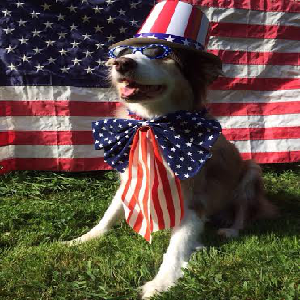

In [221]:
# Insight 4 - the tweet and dog picture with the highest rating

# first sort the dataframe according to rating_numerator
sorted_twitter_df_by_rating_numerator = twitter_master_df.sort_values(by='rating_numerator', ascending=False)

# get the tweet with the highest rating_numerator
tweet_with_highest_rating_numerator = sorted_twitter_df_by_rating_numerator.iloc[0]

# get the tweet_id with highest rating_numerator
tweet_id_with_highest_rating_numerator = tweet_with_highest_rating_numerator['tweet_id']

# get the algorithm prediction on the dog with the highest confidence
predicted_breed = image_predictions_df[image_predictions_df.tweet_id == tweet_id_with_highest_rating_numerator]["p1"].values[0]

# show output
print(f"Tweet id with highest rating_numerator: {tweet_id_with_highest_rating_numerator}")
print(f"Tweet text with highest rating_numerator:\n {tweet_with_highest_rating_numerator['text']}")
print(f"Tweet source with highest rating_numerator:\n {tweet_with_highest_rating_numerator['source']}")
print(f"Tweet retweet count with highest rating_numerator:\n {tweet_with_highest_rating_numerator['retweet_count']}")
print(f"Dog Rating with highest rating_numerator:\n {tweet_with_highest_rating_numerator['rating_numerator']}/{tweet_with_highest_rating_numerator['rating_denominator']}")
print(f"Dog name with highest rating_numerator: {tweet_with_highest_rating_numerator['name']}") 
print(f"Predicted dog breed:\n {predicted_breed}") 
      
# below we show the image of the tweet - this is where we will use the image dataset
image_url = image_predictions_df[image_predictions_df.tweet_id == tweet_id_with_highest_rating_numerator]['jpg_url'].values[0]
if image_url:
      image_res = requests.get(image_url)
i = Image.open(BytesIO(image_res.content)).resize((300,300))
i 

It can be seen that the image prediction algorithm predicted this image to be a bow tie with highest confidence, instead of a dog, probably because of the large bow tie seen in the image, that almost completely occludes the shape of the dog.

Tweet id with lowest rating_numerator: 835152434251116546
Tweet text with lowest rating_numerator:
 When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
Tweet source with lowest rating_numerator:
 iphone
Tweet retweet count with lowest rating_numerator:
 3124
Dog Rating with lowest rating_numerator:
 0/10
Predicted dog breed:
 swing


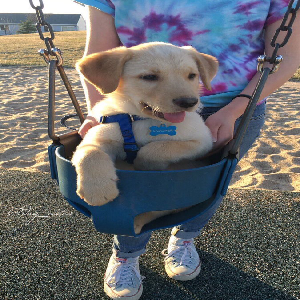

In [222]:
# Insight 5 - the tweet and dog picture with the lowest rating

# first sort the dataframe according to rating_numerator
sorted_twitter_df_by_rating_numerator = twitter_master_df.sort_values(by='rating_numerator')

# get the tweet with the lowest rating_numerator
tweet_with_lowest_rating_numerator = sorted_twitter_df_by_rating_numerator.iloc[0]

# get the tweet_id with lowest rating_numerator
tweet_id_with_lowest_rating_numerator = tweet_with_lowest_rating_numerator['tweet_id']

# get the algorithm prediction on the dog with the highest confidence
predicted_breed = image_predictions_df[image_predictions_df.tweet_id == tweet_id_with_lowest_rating_numerator]["p1"].values[0]

# show output
print(f"Tweet id with lowest rating_numerator: {tweet_id_with_lowest_rating_numerator}")
print(f"Tweet text with lowest rating_numerator:\n {tweet_with_lowest_rating_numerator['text']}")
print(f"Tweet source with lowest rating_numerator:\n {tweet_with_lowest_rating_numerator['source']}")
print(f"Tweet retweet count with lowest rating_numerator:\n {tweet_with_lowest_rating_numerator['retweet_count']}")
print(f"Dog Rating with lowest rating_numerator:\n {tweet_with_lowest_rating_numerator['rating_numerator']}/{tweet_with_lowest_rating_numerator['rating_denominator']}")
print(f"Predicted dog breed:\n {predicted_breed}") 
      
# below we show the image of the tweet - this is where we will use the image dataset
image_url = image_predictions_df[image_predictions_df.tweet_id == tweet_id_with_lowest_rating_numerator]['jpg_url'].values[0]
if image_url:
      image_res = requests.get(image_url)
i = Image.open(BytesIO(image_res.content)).resize((300,300))
i 

Again, the algorithm has predicted the image to be that of a swing with highest confidence. This is probably due to the larger appearance of the swing when compared to the dog's shape.

Text(0.5, 1.0, 'Correlation between retweet count and favorite count')

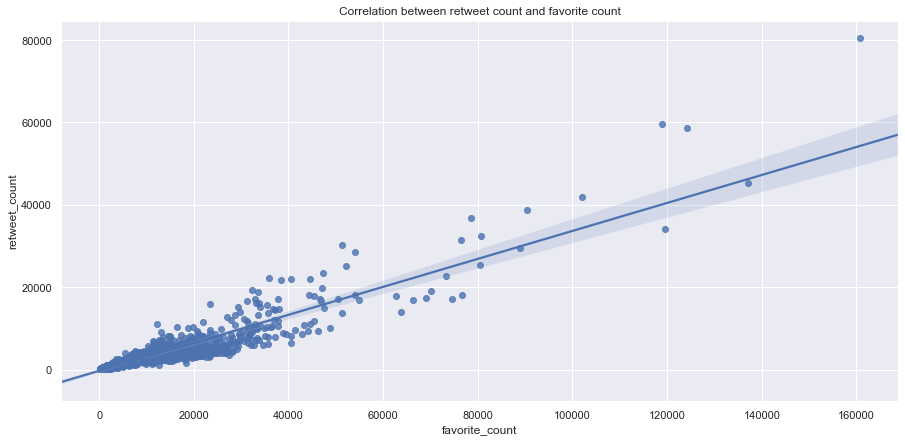

In [223]:
# Insight 6 - Are the most retweeted tweets the most favorite tweets? - lets check via a correlation plot

f, ax = plt.subplots(1,1, figsize=(15,7))
sns.regplot(data=twitter_master_df, x='favorite_count', y='retweet_count')
ax.set_title("Correlation between retweet count and favorite count")

From the regression plot above, it is evident that there is a strong positive correlation between the retweet and favorite counts of a tweet. Hence, it can be concluded that the most favorite tweets are infact those that are also retweeted the most.